# Rise time tests-
In this script we have created a pulse waveform segment and downloaded to all the main channels of protes P9484M module and 
We will be able to test the rise time transition of the pulse by connecting the channel to the scope 

Proteus release - Aurora

Oscilloscope - KEYSIGHT TECHNOLOGIES,MSO9254A
This script includes test for channel amplitude, channel rise time and fall time.

In [1]:
#Pre-requisite for the script 
ip_address= '192.90.70.22' #input('Please enter ip address for the device') 
sampling_rate = 2e9
test_success = True
channel_on_scope = 1 # ref out of the proteus is connected to channel1 on the oscilloscope

In [2]:
## Import required Libraries
import os
import sys
import tempfile
import webbrowser
srcpath = os.path.realpath('SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from teproteus_functions_v3 import connect
from teproteus_functions_v3 import disconnect
from teproteus_functions_v3 import set_lib_dir_path
from teproteus_functions_v3 import get_cpatured_header
from teproteus_functions_v3 import gauss_env
from teproteus_functions_v3 import iq_kernel
from teproteus_functions_v3 import pack_kernel_data
from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst
# matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

plt.style.use('ggplot')
from scipy import signal
import math
import pdb

import pyvisa as visa
from pyvisa.errors import Error

# Connect to instrument
inst = connect(ip_address)

# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print(resp)

# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get number of channels
resp = inst.send_scpi_query(":INST:CHAN? MAX")
#print("Number of channels: " + resp)
num_channels = int(resp)

# Get the DAC mode (8 bits or 16 bits)
resp = inst.send_scpi_query(':SYST:INF:DAC?')
if resp == 'M0':
    dac_mode = 16
else:
    dac_mode = 8

print('DAC {0} bits'.format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

# Several initializations ..
inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:FREQ {0}'.format(sampling_rate))
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))

Service connect
Trying to connect to IP:192.90.70.22
Tabor Electronics,P9484M,000002232771,1.238.6 --Tabor Electronics,P9484M,000000000000,1.238.6 --slot#: 2, slot#: 4, 
Model: P9484M 
DAC 16 bits


## Configure Generator

In [3]:
# channel_on_scope = 1
vertical_scale_per_divison = 0.10
horizontal_scale_per_divison = 100e-12
# scope_time_scale = 2e-9
riseFall_time = 130e-12
scope_addr2= 'USB0::0x2A8D::0x900E::MY55490134::INSTR'
# connect to scope via USB
try:
    resourceManager = visa.ResourceManager()   # Create a connection (session) to the instrument
    scope = resourceManager.open_resource(scope_addr2)
except visa.Error as ex2:
        print('Couldn\'t connect to \'%s\', exiting now...' % scope_addr2)
        sys.exit()
    ## scope acquisition 
# Send *IDN? and read the response
scope.write('*RST?')
scope.write('*IDN?')
idn = scope.read()
print('*IDN? returned: %s' % idn.rstrip('\n'))

*IDN? returned: KEYSIGHT TECHNOLOGIES,MSO9254A,MY55490134,06.40.01101


Rise time :133.0ps
TEST FAILED for rise time on channel 1
Rise time :137.4ps
TEST FAILED for rise time on channel 2
Rise time :134.73999999999998ps
TEST FAILED for rise time on channel 3
Rise time :131.36ps
TEST FAILED for rise time on channel 4


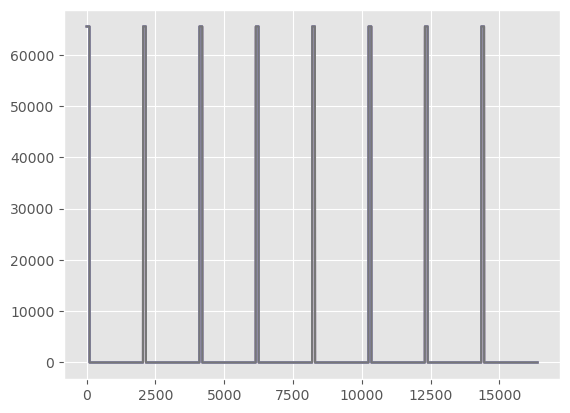

In [4]:
# Build two AWG segment that will be used as innput for the digitizer
cycleLen = 1024*2
numCycles = 8
segLen = cycleLen * numCycles
segnum = 1
# waves = []

# Build waveform (sine wave)
x = np.linspace(start=0, stop=segLen, num=segLen, endpoint=False)

y = np.fmod(x,cycleLen)
y = (y <= cycleLen/20)*max_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# y = (np.sin(x)+1.0)* half_dac
# #y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
# y = np.round(y)
# y = np.clip(y, 0, max_dac)
# y = y.astype(data_type)
# download it to segment 2 of channel 1
for i in range(num_channels):
    channb = i+1
    inst.send_scpi_cmd(':INST:CHAN {}'.format(channb))
    inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
    inst.send_scpi_cmd(':TRAC:SEL 1')
    inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
    inst.send_scpi_cmd(':SOUR:VOLT 0.5')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    inst.timeout = 30000
    inst.send_scpi_cmd(':TRAC:SEL 1')
    inst.write_binary_data(':TRAC:DATA', y)
    inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
    inst.send_scpi_cmd(':OUTP ON')
    resp = inst.send_scpi_query(':SYST:ERR?')
    
    plt.plot(x,y)
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))
        
    #scope.write('*CLS;:DISPlay:CGRade:LEVels ')
    scope.write('*RST;:CHAN{0}:DISP ON;:TIMebase:SCALe {1}'.format(channb,horizontal_scale_per_divison))
    scope.write(':TRIGger:SWEep TRIGgered')
    scope.write(':TRIGger:MODE EDGE')
    scope.write(':TRIGger:EDGE:SOURce CHANnel{}'.format(channb))
    scope.write(':CHAN{0}:SCAL {1};:CHAN{0}:INP DC50'.format(channb,vertical_scale_per_divison))
    #scope.write('*RST;:CHAN{0}:DISP ON;'.format(channel_on_scope,scope_time_scale))
    #scope.write('*RST;:CHAN{0}:DISP ON;:TIMebase:SCALe {1}'.format(channel_on_scope,horizontal_scale_per_divison))
    #scope.write('*RST;:CHAN{0}:DISP ON;:TIMebase:POS 274e-3'.format(channb))
    scope.write(':CHANnel{}:OFFSet 274e-3'.format(channb))
    #[<source>[,<start_level>,<stop_level>]]
    time.sleep(1)
    scope.write(':MEASure:RISetime CHANnel{0},20,80'.format(channb))
    time.sleep(10)
    scope.write(':MEASure:RESults?')
    result = scope.read()
    rise_time_temp= float(result.split(',')[1])
    print("Rise time :{}ps".format(rise_time_temp/1e-12))
    scope.write('*RST;:CHAN{0}:DISP OFF'.format(channb))
    if rise_time_temp>riseFall_time:
        test_success = False
        print("TEST FAILED for rise time on channel {}".format(channb))
    else:
        print("TEST PASSED for rise time on channel {}".format(channb))


In [5]:
if(test_success):
    print('Test successed')
else:
     print('Test failed')
disconnect()
# Close the connection to the instrument
scope.close()
resourceManager.close()
print('Proteus disconnected successfully')

Test failed
Proteus disconnected successfully
